<a href="https://colab.research.google.com/github/z-gard/analysis/blob/main/notebooks/library.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 図書館

In [1]:
!pip install -q geocoder
!pip install -q --upgrade xlrd
!pip install -q japanize-matplotlib

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
DIR_NAME = '/content/drive/MyDrive/z-gard/data'

In [4]:
import os
import requests
import json
import pandas as pd
from urllib.parse import urlparse
import geocoder
import math
import io
import matplotlib.pyplot as plt
import japanize_matplotlib
import seaborn as sns

pd.set_option('display.max_columns', 50)
pd.set_option('display.max_rows', 100)

In [5]:
def get_data_csv_url(url, encoding='utf-8', excel=False):
    res = requests.get(url)
    if res.status_code == 200:
        if not excel:
            return pd.read_csv(io.BytesIO(res.content), encoding=encoding)
        else:
            return pd.read_excel(io.BytesIO(res.content))
    else:
        raise Exception(f'status_code: {res.status_code} ({url})')

# def number_to_kanji(str):
#     return str.translate(str.maketrans({
#         '１':'一', '２':'二', '３':'三', '４':'四', '５':'五', '６':'六', '７':'七', '８':'八', '９':'九',
#         '1':'一', '2':'二', '3':'三', '4':'四', '5':'五', '6':'六', '7':'七', '8':'八', '9':'九', '0':'十', 
#     }))

# 緯度経度取得
# def add_lat_lon(df_master):
#     lats = []
#     lons = []
#     for i, row in df_master.iterrows():
#         chocho = number_to_kanji(row['町丁目'])
#         ret = geocoder.osm('東京都' + row['市区町村名'] + chocho, timeout=5)
#         if not ret.ok:
#             print(i, row['市区町村名'], chocho)
#         lats.append(ret.lat)
#         lons.append(ret.lng)
#     df_copy = df_master.copy()
#     df_copy['緯度'] = lats
#     df_copy['経度'] = lons
#     return df_copy

# 距離計算
def get_distance(lat1, lon1, lat2, lon2):
    _lat1 = lat1 * math.pi / 180
    _lon1 = lon1 * math.pi / 180
    _lat2 = lat2 * math.pi / 180
    _lon2 = lon2 * math.pi / 180
    _tmp = math.cos(_lat1) * math.cos(_lat2) * math.cos(_lon2 - _lon1) + math.sin(_lat1) * math.sin(_lat2)
    _tmp = 1 if _tmp > 1 else -1 if _tmp < -1 else _tmp
    return 6371 * math.acos(_tmp)

# 最寄り施設までの距離
def get_value_of_nearest_facility(df_master, df_facility, category, method='min', param=3):
    _df_cat = df_facility[df_facility['施設分類'] == category].copy()
    cat_values = []
    for i, row in df_master.iterrows():
        dist = _df_cat.apply(lambda x: get_distance(x['緯度'], x['経度'], row['緯度'], row['経度']), axis=1)
        val = None
        if method == 'min':
            # 最小の距離
            val = dist.min()
        elif method == 'count':
            # {param}km以内の施設の数をカウント
            val = len(dist[dist <= param])
        elif method == 'mean':
            # 近い{param}件の距離の平均
            val = dist.sort_values()[:param].mean()
        cat_values.append(val)
    return cat_values

In [6]:
def get_distance_from_facility(longitude, latitude, df_facility):
    return df_facility.apply(lambda x: get_distance(x['緯度'], x['経度'], longitude, latitude), axis=1)

In [7]:
extract_columns = ['施設分類', '施設名', '市区町村名', '所在地', '緯度', '経度']

## 0. 東京都
- [公共施設一覧](https://catalog.data.metro.tokyo.lg.jp/dataset/t000003d0000000033/resource/27d1ce20-9023-4690-944c-5da47ed1427e)
- [図書館](https://catalog.data.metro.tokyo.lg.jp/dataset/t000021d2000000003/resource/7108f0a3-0257-424a-9722-e84999a01392)

In [8]:
tokyo_library_url = 'https://www.opendata.metro.tokyo.lg.jp/kyouiku/R3/skshubetu_4.csv'
df_tokyo_library = get_data_csv_url(tokyo_library_url, encoding='shift-jis')
print(df_tokyo_library.shape)

df_tokyo_library = df_tokyo_library[df_tokyo_library['施設名'].notna()]
df_tokyo_library = df_tokyo_library[(~df_tokyo_library['施設名'].str.contains('閉館'))&(df_tokyo_library['区市町村名'].str.endswith('区'))]
df_tokyo_library['施設名'] = df_tokyo_library['施設名'].str.replace('＊\?', '', regex=True).str.replace('\?\?', '', regex=True)
df_tokyo_library = df_tokyo_library.rename(columns={'施設区分':'施設分類', '区市町村名':'市区町村名'})[extract_columns].reset_index(drop=True)
print(df_tokyo_library.shape)

(418, 9)
(233, 6)


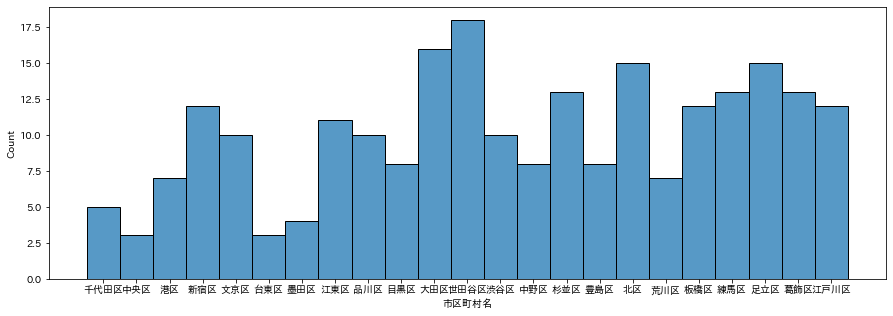

In [9]:
plt.figure(figsize=(15, 5))
sns.histplot(x='市区町村名', data=df_tokyo_library)
plt.show()

## 1. 千代田区

## 2. 中央区
- [区立図書館](https://catalog.data.metro.tokyo.lg.jp/dataset/t131024d0000000009/resource/000f73eb-36ec-46a3-af45-345602281d1d)

## 3. 港区
- [港区の公共施設情報](https://catalog.data.metro.tokyo.lg.jp/dataset/t131032d0000000014)

In [10]:
# minato_library_url = 'https://opendata.city.minato.tokyo.jp/dataset/52105970-c407-423c-8827-2cfc229bf864/resource/dc824430-1645-45f6-8dc1-229b2d2c97a2/download/minatokushisetsujoho_tosyokan.csv'
# df_minato_library = get_data_csv_url(minato_library_url)
# df_minato_library['市区町村名'] = '港区'
# df_minato_library = df_minato_library[df_minato_library['第2分類'] == '図書館'].reset_index(drop=False)
# df_minato_library = df_minato_library.rename(columns={'第2分類':'施設分類', 'ページタイトル':'施設名'})[extract_columns]
# print(df_minato_library.shape)

## 4. 新宿区

## 5. 文京区
- [区立図書館](https://catalog.data.metro.tokyo.lg.jp/dataset/t131059d0313060001/resource/7479e54e-2afb-4598-83dc-5a258c9f9c68)

## 6. 台東区
- [図書館](https://catalog.data.metro.tokyo.lg.jp/dataset/t131067d0000000090/resource/642d35ad-56fa-4d9f-b364-45aa615da5a6)

In [11]:
# taito_library_url = 'https://www.city.taito.lg.jp/kusei/online/opendata/seikatu/shisethutizujouhou.files/sisetu_12.csv'
# df_taito_library = get_data_csv_url(taito_library_url, 'shift-jis')
# df_taito_library['市区町村名'] = '台東区'
# df_taito_library['施設分類'] = '図書館'
# df_taito_library = df_taito_library.rename(columns={'名称':'施設名', 'X座標':'経度', 'Y座標':'緯度'})[extract_columns]
# print(df_taito_library.shape)

## 7. 墨田区

In [12]:
# sumida_library_url = 'https://www.city.sumida.lg.jp/kuseijoho/sumida_info/opendata/opendata_ichiran/shisetsu_data.files/library.csv'
# df_sumida_library = get_data_csv_url(sumida_library_url, 'shift-jis')
# df_sumida_library['市区町村名'] = '墨田区'
# df_sumida_library['施設分類'] = '図書館'
# df_sumida_library = df_sumida_library.rename(columns={'施設名称':'施設名'})[extract_columns]
# print(df_sumida_library.shape)

## 8. 江東区

## 9. 品川区

## 10. 目黒区

## 11. 大田区
- [図書館一覧](https://catalog.data.metro.tokyo.lg.jp/dataset/t131113d0000000021/resource/b73e2be9-5f66-4539-9449-e2b2e3d06f31)

## 12. 世田谷区

## 13. 渋谷区

## 14. 中野区

## 15. 杉並区

## 16. 豊島区

## 17. 北区

## 18. 荒川区

## 19. 板橋区
- [板橋区の図書館](https://catalog.data.metro.tokyo.lg.jp/dataset/t131199d0000001381/resource/81734445-ec05-47c7-9fa4-0495af2d030a)

## 20. 練馬区

In [13]:
# nerima_library_url = 'https://www.city.nerima.tokyo.jp/kusei/tokei/opendata/opendatasite/sisetsujyouhou/toshokan.files/toshokan.csv'
# df_nerima_library = get_data_csv_url(nerima_library_url, 'shift-jis')
# df_nerima_library['市区町村名'] = '練馬区'
# df_nerima_library = df_nerima_library[~df_nerima_library['名称'].str.contains('受取窓口')].reset_index(drop=True)
# df_nerima_library['施設分類'] = '図書館'
# df_nerima_library = df_nerima_library.rename(columns={'名称':'施設名'})[extract_columns]
# print(df_nerima_library.shape)

## 21. 足立区

## 22. 葛飾区

## 23. 江戸川区

## 図書館マスタ

|No.|区名|データ|
|:----|:----|:----|
|0|東京都|済み|
|1|千代田区| |
|2|中央区| |
|3|港区|使用しない|
|4|新宿区| |
|5|文京区| |
|6|台東区|使用しない|
|7|墨田区|使用しない|
|8|江東区| |
|9|品川区| |
|10|目黒区| |
|11|大田区| |
|12|世田谷区| |
|13|渋谷区| |
|14|中野区| |
|15|杉並区| |
|16|豊島区| |
|17|北区| |
|18|荒川区| |
|19|板橋区| |
|20|練馬区|使用しない|
|21|足立区| |
|22|葛飾区| |
|23|江戸川区| |

In [14]:
# df_library_master = pd.concat([
#     df_minato_library,
#     df_sumida_library,
#     df_nerima_library,
#     df_taito_library,
# ]).reset_index(drop=True)
# print(df_library_master.shape)

df_library_master = df_tokyo_library

In [15]:
df_library_master.head()

,施設分類,施設名,市区町村名,所在地,緯度,経度
0,図書館,昌平まちかど図書館,千代田区,千代田区外神田3-4-7,35.701223,139.769873
1,図書館,神田まちかど図書館,千代田区,千代田区神田司町2-16,35.693357,139.768304
2,図書館,四番町図書館,千代田区,千代田区四番町1,35.690453,139.741601
3,図書館,千代田図書館,千代田区,千代田区九段南1-2-1千代田区役所9･10階,35.693997,139.753585
4,図書館,日比谷図書文化館,千代田区,千代田区日比谷公園1-4,35.671872,139.754602


In [16]:
df_library_master.to_csv(os.path.join(DIR_NAME, 'library_master.csv'), index=False)

In [17]:
# データがある区をリストアップ
sr_library_count = df_library_master[df_library_master['施設分類'] == '図書館']['市区町村名'].value_counts()
ward_list = list(sr_library_count.index)
assert len(ward_list) == 23

## 人口マスタ

In [18]:
population_master = pd.read_csv(os.path.join(DIR_NAME, 'population_master.csv'))
print(population_master.shape)

(2921, 32)


In [19]:
df_tokyo_district_master = population_master[population_master['市区町村名'].isin(ward_list)][['地域ID', '市区町村名', '町名', '町丁目', '緯度', '経度']].copy()
print(df_tokyo_district_master.shape)

(2921, 6)


In [20]:
%%time
# 一番近い施設の距離
df_tokyo_district_master['図書館(最近傍距離)'] = get_value_of_nearest_facility(df_tokyo_district_master, df_library_master, '図書館', 'min')
# 近い3件の距離の平均
df_tokyo_district_master['図書館(平均距離)'] = get_value_of_nearest_facility(df_tokyo_district_master, df_library_master, '図書館', 'mean', 3)
# 2km以内の施設の数
df_tokyo_district_master['図書館(数)'] = get_value_of_nearest_facility(df_tokyo_district_master, df_library_master, '図書館', 'count', 2)

CPU times: user 1min 2s, sys: 300 ms, total: 1min 2s
Wall time: 1min 7s


In [21]:
print(df_tokyo_district_master.shape)
df_tokyo_district_master.head()

(2921, 9)


,地域ID,市区町村名,町名,町丁目,緯度,経度,図書館(最近傍距離),図書館(平均距離),図書館(数)
0,101003,千代田区,丸の内,丸の内１丁目,35.681610,139.767511,1.286453,1.301848,5
1,101004,千代田区,丸の内,丸の内２丁目,35.680071,139.763944,1.242295,1.349516,5
2,101005,千代田区,丸の内,丸の内３丁目,35.676890,139.764039,1.000856,1.274480,4
3,101007,千代田区,大手町,大手町１丁目,35.688067,139.764353,0.687988,1.136131,5
4,101008,千代田区,大手町,大手町２丁目,35.686416,139.768530,0.772108,1.182786,6


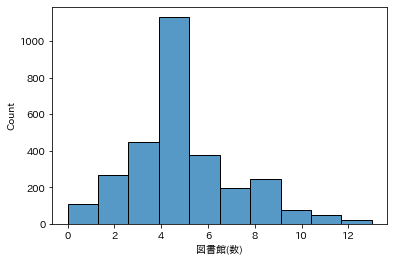

In [22]:
sns.histplot(df_tokyo_district_master['図書館(数)'], bins=10)
plt.show()

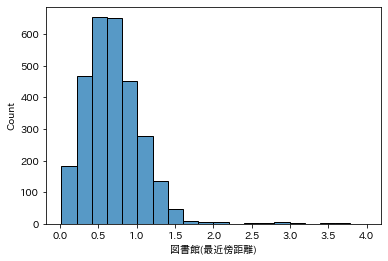

In [23]:
sns.histplot(df_tokyo_district_master['図書館(最近傍距離)'], bins=20)
plt.show()

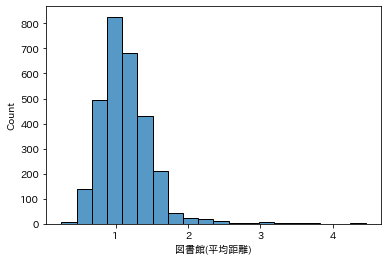

In [24]:
sns.histplot(df_tokyo_district_master['図書館(平均距離)'], bins=20)
plt.show()

In [25]:
def normalize_score(sr_data, high=True, outlier=True):
    score = (sr_data - sr_data.mean())/sr_data.std()
    score = score if high else -score

    if outlier:
        high_s = score.quantile(0.99)
        low_s = score.quantile(0.01)
        score[score > high_s] = high_s
        score[score < low_s] = low_s
    else:
        high_s = score.max()
        low_s = score.min()
        
    return (score - low_s)/(high_s - low_s)


def rank_score(sr_data):
    size = sr_data.notna().sum()
    rank = sr_data.rank()
    result = rank.copy()
    # 0~1: 15%, 1~2: 20%, 2~3: 30%, 3~4: 20%, 4~5: 15%
    level_list = [0.15, (0.15+0.2), (0.15+0.2+0.3), (0.15+0.2+0.3+0.2), 1]
    
    pre_level = 0
    for index, level in enumerate([lv*size for lv in level_list]):
        result[(rank > pre_level)&(rank <= level)] = (rank - pre_level)/(level - pre_level) + index
        pre_level = level

    return result

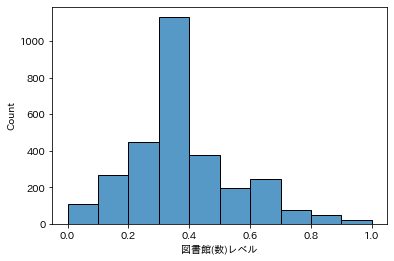

In [26]:
df_tokyo_district_master['図書館(数)レベル'] = normalize_score(df_tokyo_district_master['図書館(数)'], outlier=False)
sns.histplot(df_tokyo_district_master['図書館(数)レベル'], bins=10)
plt.show()

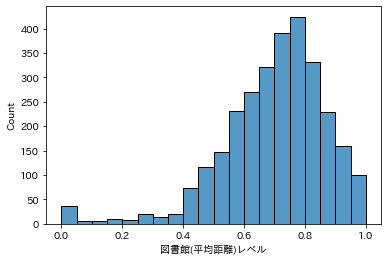

In [27]:
df_tokyo_district_master['図書館(平均距離)レベル'] = normalize_score(df_tokyo_district_master['図書館(平均距離)'], False)
sns.histplot(df_tokyo_district_master['図書館(平均距離)レベル'], bins=20)
plt.show()

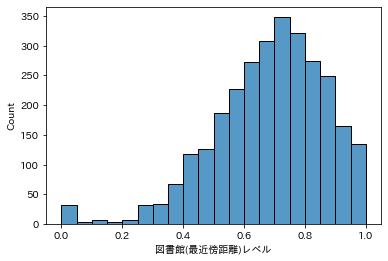

In [28]:
df_tokyo_district_master['図書館(最近傍距離)レベル'] = normalize_score(df_tokyo_district_master['図書館(最近傍距離)'], False)
sns.histplot(df_tokyo_district_master['図書館(最近傍距離)レベル'], bins=20)
plt.show()

In [29]:
score_list = [
    df_tokyo_district_master['図書館(最近傍距離)レベル'] * 1.0,
    df_tokyo_district_master['図書館(平均距離)レベル'] * 0.7,
    df_tokyo_district_master['図書館(数)レベル'] * 0.5,
]
df_tokyo_district_master['_図書館スコア'] = normalize_score(pd.concat(score_list, axis=1).sum(axis=1, skipna=False), outlier=False)
df_tokyo_district_master['図書館スコア'] = rank_score(df_tokyo_district_master['_図書館スコア'])

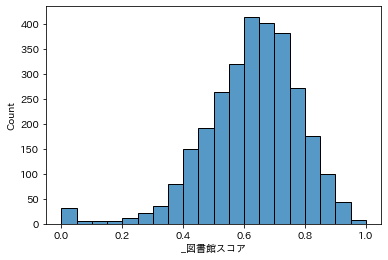

In [30]:
sns.histplot(df_tokyo_district_master['_図書館スコア'], bins=20)
plt.show()

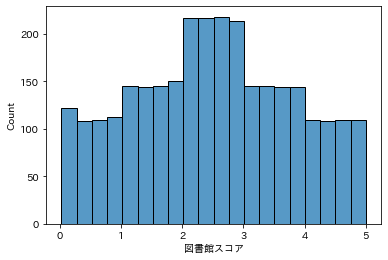

In [31]:
sns.histplot(df_tokyo_district_master['図書館スコア'], bins=20)
plt.show()

In [32]:
df_tokyo_district_master[['地域ID', '市区町村名', '町丁目', '図書館(最近傍距離)', '図書館(平均距離)', '図書館(数)', '図書館スコア']]\
    .to_csv(os.path.join(DIR_NAME, 'library_score.csv'), index=False)

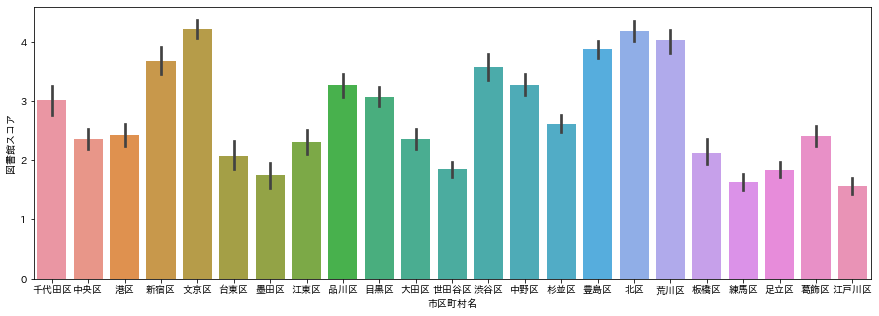

In [33]:
plt.figure(figsize=(15, 5))
sns.barplot(x='市区町村名', y='図書館スコア', data=df_tokyo_district_master)
plt.show()

In [34]:
df_library_level = df_tokyo_district_master.copy()
df_library_level['rank'] = df_library_level.groupby('町名')['図書館スコア'].transform('rank', ascending=False)
df_library_level = df_library_level[df_library_level['rank'] == 1].sort_values('図書館スコア', ascending=False)[
    ['市区町村名', '町名', '町丁目', '図書館スコア', '_図書館スコア', '図書館(最近傍距離)', '図書館(平均距離)', '図書館(数)']
].reset_index(drop=True)
print(df_library_level.shape)

(695, 8)


In [35]:
df_library_level.head(20)

,市区町村名,町名,町丁目,図書館スコア,_図書館スコア,図書館(最近傍距離),図書館(平均距離),図書館(数)
0,北区,上中里,上中里１丁目,5.000000,1.000000,0.126370,0.529664,13
1,北区,田端新町,田端新町２丁目,4.997711,0.991115,0.135295,0.581013,13
2,北区,上十条,上十条３丁目,4.995423,0.987172,0.081841,0.572226,12
3,中野区,東中野,東中野１丁目,4.993134,0.965534,0.104376,0.566147,11
4,北区,田端,田端２丁目,4.990846,0.964483,0.127197,0.434601,11
5,荒川区,西日暮里,西日暮里６丁目,4.988557,0.961340,0.140458,0.510588,11
6,文京区,本駒込,本駒込４丁目,4.986268,0.960356,0.144613,0.416272,11
7,北区,東十条,東十条３丁目,4.983980,0.951047,0.025586,0.577180,10
8,北区,昭和町,昭和町３丁目,4.981691,0.947688,0.092581,0.584521,10
9,新宿区,大久保,大久保２丁目,4.977114,0.941707,0.148785,0.250977,10


In [36]:
df_library_level.tail(20)

,市区町村名,町名,町丁目,図書館スコア,_図書館スコア,図書館(最近傍距離),図書館(平均距離),図書館(数)
675,江東区,潮見,潮見２丁目,0.599611,0.425953,1.042739,1.650518,3
676,世田谷区,野毛,野毛１丁目,0.542396,0.416903,0.810042,1.828520,1
677,世田谷区,宇奈根,宇奈根１丁目,0.537819,0.415636,0.747611,1.927532,1
678,江戸川区,北篠崎,北篠崎２丁目,0.505779,0.408385,1.313447,1.472211,4
679,墨田区,吾妻橋,吾妻橋１丁目,0.480604,0.403914,1.271064,1.561686,4
680,練馬区,三原台,三原台２丁目,0.460007,0.401364,1.079937,1.638889,2
681,墨田区,太平,太平１丁目,0.455430,0.401217,1.050761,1.682418,2
682,板橋区,新河岸,新河岸１丁目,0.427967,0.396014,1.125800,1.604871,2
683,練馬区,谷原,谷原６丁目,0.411946,0.393546,1.076836,1.691609,2
684,墨田区,東駒形,東駒形３丁目,0.377618,0.387220,1.241179,1.599386,3
